# 0.0 Initial

## 0.1 Imports & Functions

In [362]:
import sqlite3
import pandas.io.sql    as  psql

import numpy            as  np
import pandas           as  pd
import seaborn          as  sns

from sklearn.model_selection    import  train_test_split
from matplotlib                 import  pyplot              as plt

plt.figure(figsize=(20,15));

<Figure size 2000x1500 with 0 Axes>

In [363]:
# Function to connect to the database.
def connect_db(base = 'db_olist.sqlite'):
    # To connect to the SQLite database (the file will be created if it doesn't exist)
    return sqlite3.connect(base)

def execute_query_db(query, cursor):
    # Drop the temporary table if it exists.
    cursor.execute(query)


## 0.2 Database connection and execution of auxiliary queries.

In [364]:
# Connet to database
conn = connect_db();

# Create a cursor
cursor = conn.cursor();

# Execute DROP TABLE
execute_query_db("DROP TABLE IF EXISTS geolocation_temporary;", cursor);

# Execute Creation of the temporary table.
execute_query_db("""
    CREATE TEMPORARY TABLE geolocation_temporary (
        geolocation_zip_code_prefix INTEGER,
        count INTEGER,
        min_lat REAL,
        media_lat REAL,
        max_lat REAL,
        random_num REAL,
        min_lng REAL,
        media_lng REAL,
        max_lng REAL
    );
""", cursor);

# Insertion of data into the temporary table
execute_query_db("""
    INSERT INTO geolocation_temporary
    SELECT
        geolocation_zip_code_prefix,
        COUNT(geolocation_zip_code_prefix),
        MIN(geolocation_lat) AS min_lat,
        AVG(geolocation_lat) AS media_lat,
        MAX(geolocation_lat) AS max_lat,
        ABS(RANDOM())/10000000000000000000 AS random_num,
        MIN(geolocation_lng) AS min_lng,
        AVG(geolocation_lng) AS media_lng,
        MAX(geolocation_lng) AS max_lng
    FROM geolocation
    GROUP BY geolocation_zip_code_prefix
    ORDER BY geolocation_zip_code_prefix;
""", cursor);

## 0.3 Main query

In [365]:
# Main query
query = """
    SELECT
        ROW_NUMBER() OVER () AS row_number,
        ABS(RANDOM())/10000000000000000000 AS random_num ,
        o.order_id ,
        o.customer_id ,
        o.order_status ,
        o.order_approved_at  ,
        o.order_delivered_customer_date  ,
        o.order_estimated_delivery_date ,
        oi.product_id ,
        oi.seller_id ,
        c.customer_zip_code_prefix ,
        s.seller_zip_code_prefix ,
        gc.media_lat AS MEDIA_LAT_CUSTOMER,
        gc.media_lng AS MEDIA_LNG_CUSTOMER,
        gs.media_lat AS MEDIA_LAT_SELLER,
        gs.media_lng AS MEDIA_LNG_SELLER,
        SQRT(POW(gc.media_lat - gs.media_lat, 2) + POW(gc.media_lng - gs.media_lng, 2)) AS dist_degrees,
        p.product_weight_g ,
        (p.product_length_cm * p.product_height_cm * p.product_width_cm) AS product_volume_cm2 ,
        p.product_category_name,
        julianday(o.order_delivered_customer_date) - julianday(o.order_approved_at) AS delta_time_real,
        julianday(o.order_estimated_delivery_date) - julianday(o.order_approved_at) AS delta_time_dataset,
        julianday(o.order_estimated_delivery_date) - julianday(o.order_delivered_customer_date) AS error_model_dataset
    FROM orders o 
    INNER JOIN order_items oi ON o.order_id = oi.order_id
    INNER JOIN customer c ON c.customer_id = o.customer_id 
    INNER JOIN sellers s ON oi.seller_id = s.seller_id 
    INNER JOIN geolocation_temporary gc ON gc.geolocation_zip_code_prefix = c.customer_zip_code_prefix
    INNER JOIN geolocation_temporary gs ON gs.geolocation_zip_code_prefix = s.seller_zip_code_prefix
    INNER JOIN products p ON p.product_id = oi.product_id
    WHERE 1=1
    AND o.order_status = 'delivered'
    AND o.order_approved_at is NOT NULL
    AND o.order_delivered_customer_date is not null
    AND o.order_estimated_delivery_date  is not null
    AND gs.media_lat is not null
    AND gs.media_lng is not null
    AND gc.media_lat is not null
    AND gc.media_lng is not null
    AND p.product_category_name IS NOT NULL
    AND p.product_weight_g <> 0
    AND delta_time_real > 0;

"""
# Return selection in dataframe format
df = psql.read_sql( query, conn )

# Close cursor and connect
cursor.close()
conn.close()

## 0.4 Prepare data

- At this point, we can set up a table with 1 response variable and 3 explanatory variables.

### 0.4.1 Separate explanatory and response variables

In [366]:
df.head(1)

,row_number,random_num,order_id,customer_id,order_status,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,MEDIA_LNG_CUSTOMER,MEDIA_LAT_SELLER,MEDIA_LNG_SELLER,dist_degrees,product_weight_g,product_volume_cm2,product_category_name,delta_time_real,delta_time_dataset,error_model_dataset
0,1,0.475986,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,-46.587161,-23.680729,-46.444238,0.176608,500.0,1976.0,utilidades_domesticas,8.429144,15.536632,7.107488


In [367]:
df.columns

Index(['row_number', 'random_num', 'order_id', 'customer_id', 'order_status',
       'order_approved_at', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_id', 'seller_id',
       'customer_zip_code_prefix', 'seller_zip_code_prefix',
       'MEDIA_LAT_CUSTOMER', 'MEDIA_LNG_CUSTOMER', 'MEDIA_LAT_SELLER',
       'MEDIA_LNG_SELLER', 'dist_degrees', 'product_weight_g',
       'product_volume_cm2', 'product_category_name', 'delta_time_real',
       'delta_time_dataset', 'error_model_dataset'],
      dtype='object')

In [368]:
# X_0 = df.drop(columns=['delta_time_real'])
X_0 = df.copy()
y_0 = df['delta_time_real'].copy()

### 0.4.2 Data for testing and training

In [369]:
X_train, X_test, y_train, y_test = train_test_split( X_0, y_0, test_size=0.3, random_state=42)

In [370]:
len(X_train), len(X_test)

(75621, 32409)

# 1.0 Analysis

In [371]:
df_1 = X_train.copy()

In [372]:
df_1.columns

Index(['row_number', 'random_num', 'order_id', 'customer_id', 'order_status',
       'order_approved_at', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_id', 'seller_id',
       'customer_zip_code_prefix', 'seller_zip_code_prefix',
       'MEDIA_LAT_CUSTOMER', 'MEDIA_LNG_CUSTOMER', 'MEDIA_LAT_SELLER',
       'MEDIA_LNG_SELLER', 'dist_degrees', 'product_weight_g',
       'product_volume_cm2', 'product_category_name', 'delta_time_real',
       'delta_time_dataset', 'error_model_dataset'],
      dtype='object')

## 1.1 Data Analysis before Linear Regression Models.

- Let's perform some analysis on the development portion (the 70% of the dataset)

In [373]:
df_aux = df_1[['dist_degrees', 'product_weight_g', 'product_volume_cm2', 'delta_time_real', 'delta_time_dataset', 'error_model_dataset']].copy()

In [374]:
# Data for the table
df_aux = {
    'dist_degrees'          : [len(df_aux), df_aux['dist_degrees'].mean(),        df_aux['dist_degrees'].median(),        df_aux['dist_degrees'].std(),        (np.percentile(df_aux['dist_degrees'], 75) - np.percentile(df_aux['dist_degrees'], 25)),               df_aux['dist_degrees'].min(),        np.percentile(df_aux['dist_degrees'], 25),        np.percentile(df_aux['dist_degrees'], 50),        np.percentile(df_aux['dist_degrees'], 75),        df_aux['dist_degrees'].max()        ],
    'product_weight_g'      : [len(df_aux), df_aux['product_weight_g'].mean(),    df_aux['product_weight_g'].median(),    df_aux['product_weight_g'].std(),    (np.percentile(df_aux['product_weight_g'], 75) - np.percentile(df_aux['product_weight_g'], 25)),       df_aux['product_weight_g'].min(),    np.percentile(df_aux['product_weight_g'], 25),    np.percentile(df_aux['product_weight_g'], 50),    np.percentile(df_aux['product_weight_g'], 75),    df_aux['product_weight_g'].max()    ],
    'product_volume_cm2'    : [len(df_aux), df_aux['product_volume_cm2'].mean(),  df_aux['product_volume_cm2'].median(),  df_aux['product_volume_cm2'].std(),  (np.percentile(df_aux['product_volume_cm2'], 75) - np.percentile(df_aux['product_volume_cm2'], 25)),   df_aux['product_volume_cm2'].min(),  np.percentile(df_aux['product_volume_cm2'], 25),  np.percentile(df_aux['product_volume_cm2'], 50),  np.percentile(df_aux['product_volume_cm2'], 75),  df_aux['product_volume_cm2'].max()  ],
    'delta_time_real'       : [len(df_aux), df_aux['delta_time_real'].mean(),     df_aux['delta_time_real'].median(),     df_aux['delta_time_real'].std(),     (np.percentile(df_aux['delta_time_real'], 75) - np.percentile(df_aux['delta_time_real'], 25)),         df_aux['delta_time_real'].min(),     np.percentile(df_aux['delta_time_real'], 25),     np.percentile(df_aux['delta_time_real'], 50),     np.percentile(df_aux['delta_time_real'], 75),     df_aux['delta_time_real'].max()     ],
    'delta_time_dataset'    : [len(df_aux), df_aux['delta_time_dataset'].mean(),  df_aux['delta_time_dataset'].median(),  df_aux['delta_time_dataset'].std(),  (np.percentile(df_aux['delta_time_dataset'], 75) - np.percentile(df_aux['delta_time_dataset'], 25)),   df_aux['delta_time_dataset'].min(),  np.percentile(df_aux['delta_time_dataset'], 25),  np.percentile(df_aux['delta_time_dataset'], 50),  np.percentile(df_aux['delta_time_dataset'], 75),  df_aux['delta_time_dataset'].max()  ],
    'error_model_dataset'   : [len(df_aux), df_aux['error_model_dataset'].mean(), df_aux['error_model_dataset'].median(), df_aux['error_model_dataset'].std(), (np.percentile(df_aux['error_model_dataset'], 75) - np.percentile(df_aux['error_model_dataset'], 25)), df_aux['error_model_dataset'].min(), np.percentile(df_aux['error_model_dataset'], 25), np.percentile(df_aux['error_model_dataset'], 50), np.percentile(df_aux['error_model_dataset'], 75), df_aux['error_model_dataset'].max() ]
}

# Row names
row_names = [
    'Count',
    'Média',
    'Mediana',
    'Desvio-Padrão',
    'Intervalo Interquartílico',
    'Mínimo',
    '1o Quartil',
    '2o Quartil',
    '3o Quartil',
    'Máximo'
]

table_df = pd.DataFrame(df_aux, index=row_names)

# Print table
table_df


,dist_degrees,product_weight_g,product_volume_cm2,delta_time_real,delta_time_dataset,error_model_dataset
Count,75621.000000,75621.000000,75621.000000,75621.000000,75621.000000,75621.000000
Média,5.540204,2102.777139,15281.121818,12.056747,23.384974,11.328227
Mediana,4.074284,700.000000,6600.000000,9.823530,22.801806,12.043495
Desvio-Padrão,5.352787,3746.638681,23321.244782,9.422571,8.839821,10.160485
Intervalo Interquartílico,5.598234,1500.000000,15612.000000,8.730718,10.129942,9.841343
Mínimo,0.000000,2.000000,168.000000,0.007662,-1.920231,-188.975081
1o Quartil,1.776080,300.000000,2856.000000,6.305544,17.989907,6.476053
2o Quartil,4.074284,700.000000,6600.000000,9.823530,22.801806,12.043495
3o Quartil,7.374314,1800.000000,18468.000000,15.036262,28.119850,16.317396
Máximo,48.219429,40425.000000,296208.000000,208.338808,153.576030,146.016123


In [375]:
# Print table
table_df


,dist_degrees,product_weight_g,product_volume_cm2,delta_time_real,delta_time_dataset,error_model_dataset
Count,75621.000000,75621.000000,75621.000000,75621.000000,75621.000000,75621.000000
Média,5.540204,2102.777139,15281.121818,12.056747,23.384974,11.328227
Mediana,4.074284,700.000000,6600.000000,9.823530,22.801806,12.043495
Desvio-Padrão,5.352787,3746.638681,23321.244782,9.422571,8.839821,10.160485
Intervalo Interquartílico,5.598234,1500.000000,15612.000000,8.730718,10.129942,9.841343
Mínimo,0.000000,2.000000,168.000000,0.007662,-1.920231,-188.975081
1o Quartil,1.776080,300.000000,2856.000000,6.305544,17.989907,6.476053
2o Quartil,4.074284,700.000000,6600.000000,9.823530,22.801806,12.043495
3o Quartil,7.374314,1800.000000,18468.000000,15.036262,28.119850,16.317396
Máximo,48.219429,40425.000000,296208.000000,208.338808,153.576030,146.016123


In [376]:
df_aux = df_1[['dist_degrees', 'product_weight_g', 'product_volume_cm2', 'delta_time_real']]
len(df_aux)

75621

### 1.1.1 Calculating the covariance matrix of the 3 explanatory variables and the response variable
- 3 explanatory ['dist_degrees', 'product_weight_g', 'product_volume_cm2'] and 1 response ['delta_time_real']



In [377]:
# Calculate covariance matrix
covr = df_aux.cov()
covr

,dist_degrees,product_weight_g,product_volume_cm2,delta_time_real
dist_degrees,28.652324,-1.512802e+02,-1.306396e+03,19.991098
product_weight_g,-151.280249,1.403730e+07,7.043968e+07,3132.092343
product_volume_cm2,-1306.395685,7.043968e+07,5.438805e+08,17873.917359
delta_time_real,19.991098,3.132092e+03,1.787392e+04,88.784846


<Axes: >

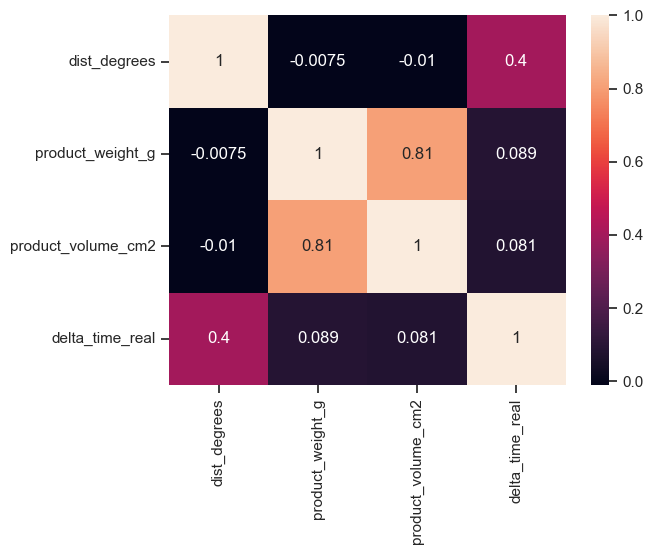

In [378]:
# Calculate correlation matrix
corr = df_aux.corr()
sns.heatmap(corr, annot=True)

### 1.1.2 Charts for analysis
- histogram for each of the 3 explanatory variables and the variable
response.

- 3 graphs showing the association of each of the 3 variables
explanations with the response variable.

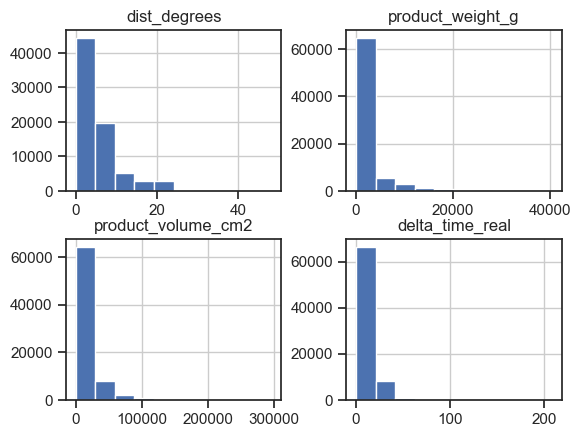

In [379]:
df_aux.hist();

In [380]:
df_aux.head()

,dist_degrees,product_weight_g,product_volume_cm2,delta_time_real
92861,0.321088,150.0,2210.0,4.283044
25339,4.186255,2500.0,12000.0,14.432280
78086,21.694852,233.0,1040.0,18.638461
27622,2.104776,500.0,2560.0,8.069815
32512,0.765133,900.0,2400.0,10.610648


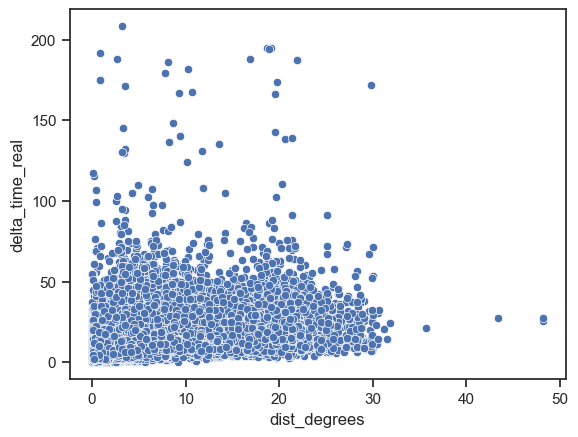

In [381]:
# 
sns.scatterplot(data=df_aux, x="dist_degrees", y="delta_time_real");

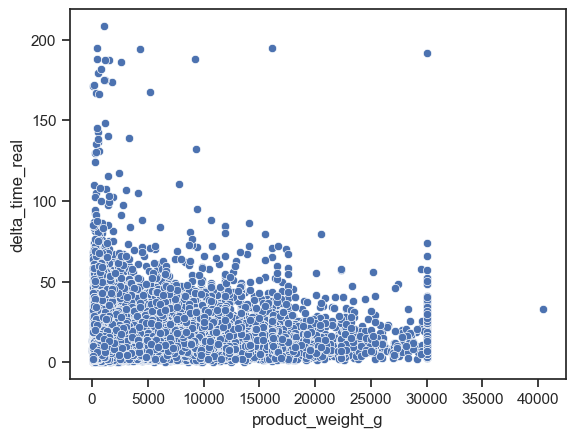

In [382]:
# 
sns.scatterplot(data=df_aux, x="product_weight_g", y="delta_time_real");

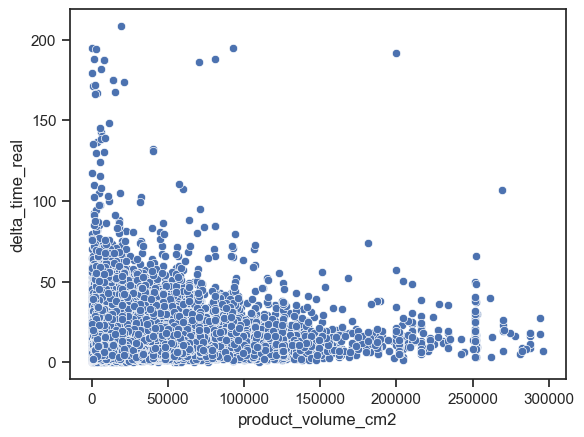

In [383]:
# 
sns.scatterplot(data=df_aux, x="product_volume_cm2", y="delta_time_real");

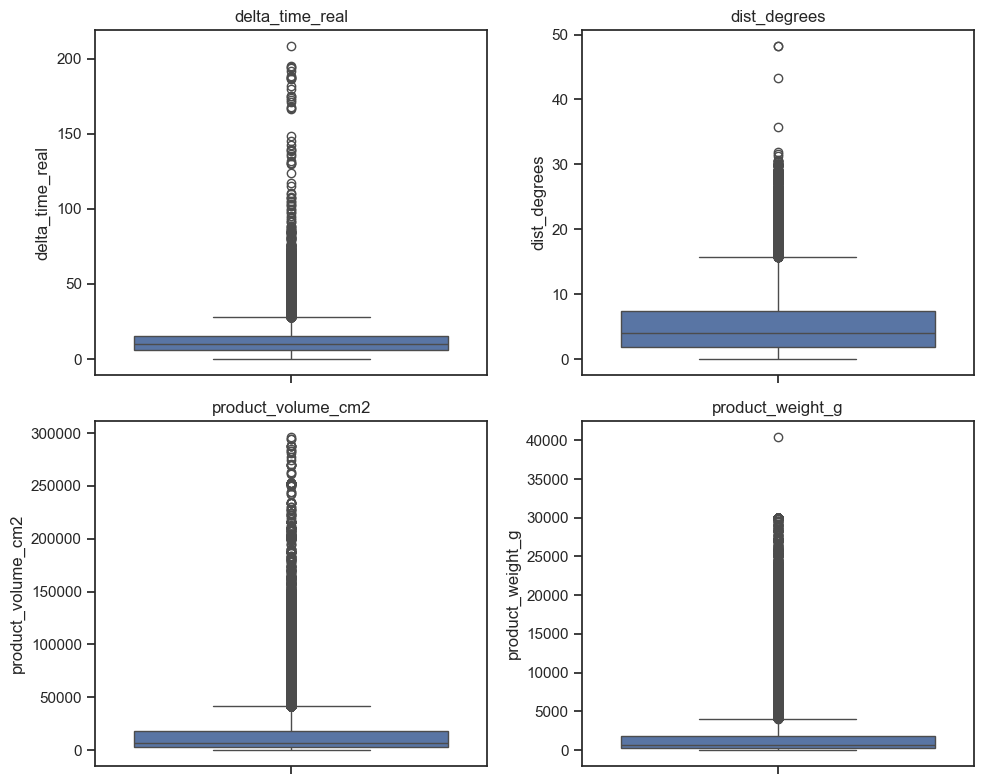

In [384]:
# Criar uma figura e uma grade de subplots com duas colunas e duas linhas
plt.figure(figsize=(10, 8))

# Primeiro subplot
plt.subplot(2, 2, 1)
sns.boxplot(df_aux['delta_time_real'])
plt.title('delta_time_real')

# Segundo subplot
plt.subplot(2, 2, 2)
sns.boxplot(df_aux['dist_degrees'])
plt.title('dist_degrees')

# Terceiro subplot
plt.subplot(2, 2, 3)
sns.boxplot(df_aux['product_volume_cm2'])
plt.title('product_volume_cm2')

# Quarto subplot
plt.subplot(2, 2, 4)
sns.boxplot(df_aux['product_weight_g'])
plt.title('product_weight_g')

# Ajustar o layout dos subplots para evitar sobreposição
plt.tight_layout()

# Exibir os subplots
plt.show()


## 1.2 Data Analysis before Linear Regression Models.

- Let's do some analysis in the validation part (the 30% of base)

In [385]:
df_1    =   X_test.copy()
df_aux  =   df_1[['dist_degrees', 'product_weight_g', 'product_volume_cm2', 'delta_time_real', 'delta_time_dataset', 'error_model_dataset']].copy()

In [386]:
# Data for the table
df_aux = {
    'dist_degrees'          : [len(df_aux), df_aux['dist_degrees'].mean(),        df_aux['dist_degrees'].median(),        df_aux['dist_degrees'].std(),        (np.percentile(df_aux['dist_degrees'], 75) - np.percentile(df_aux['dist_degrees'], 25)),               df_aux['dist_degrees'].min(),        np.percentile(df_aux['dist_degrees'], 25),        np.percentile(df_aux['dist_degrees'], 50),        np.percentile(df_aux['dist_degrees'], 75),        df_aux['dist_degrees'].max()        ],
    'product_weight_g'      : [len(df_aux), df_aux['product_weight_g'].mean(),    df_aux['product_weight_g'].median(),    df_aux['product_weight_g'].std(),    (np.percentile(df_aux['product_weight_g'], 75) - np.percentile(df_aux['product_weight_g'], 25)),       df_aux['product_weight_g'].min(),    np.percentile(df_aux['product_weight_g'], 25),    np.percentile(df_aux['product_weight_g'], 50),    np.percentile(df_aux['product_weight_g'], 75),    df_aux['product_weight_g'].max()    ],
    'product_volume_cm2'    : [len(df_aux), df_aux['product_volume_cm2'].mean(),  df_aux['product_volume_cm2'].median(),  df_aux['product_volume_cm2'].std(),  (np.percentile(df_aux['product_volume_cm2'], 75) - np.percentile(df_aux['product_volume_cm2'], 25)),   df_aux['product_volume_cm2'].min(),  np.percentile(df_aux['product_volume_cm2'], 25),  np.percentile(df_aux['product_volume_cm2'], 50),  np.percentile(df_aux['product_volume_cm2'], 75),  df_aux['product_volume_cm2'].max()  ],
    'delta_time_real'       : [len(df_aux), df_aux['delta_time_real'].mean(),     df_aux['delta_time_real'].median(),     df_aux['delta_time_real'].std(),     (np.percentile(df_aux['delta_time_real'], 75) - np.percentile(df_aux['delta_time_real'], 25)),         df_aux['delta_time_real'].min(),     np.percentile(df_aux['delta_time_real'], 25),     np.percentile(df_aux['delta_time_real'], 50),     np.percentile(df_aux['delta_time_real'], 75),     df_aux['delta_time_real'].max()     ],
    'delta_time_dataset'    : [len(df_aux), df_aux['delta_time_dataset'].mean(),  df_aux['delta_time_dataset'].median(),  df_aux['delta_time_dataset'].std(),  (np.percentile(df_aux['delta_time_dataset'], 75) - np.percentile(df_aux['delta_time_dataset'], 25)),   df_aux['delta_time_dataset'].min(),  np.percentile(df_aux['delta_time_dataset'], 25),  np.percentile(df_aux['delta_time_dataset'], 50),  np.percentile(df_aux['delta_time_dataset'], 75),  df_aux['delta_time_dataset'].max()  ],
    'error_model_dataset'   : [len(df_aux), df_aux['error_model_dataset'].mean(), df_aux['error_model_dataset'].median(), df_aux['error_model_dataset'].std(), (np.percentile(df_aux['error_model_dataset'], 75) - np.percentile(df_aux['error_model_dataset'], 25)), df_aux['error_model_dataset'].min(), np.percentile(df_aux['error_model_dataset'], 25), np.percentile(df_aux['error_model_dataset'], 50), np.percentile(df_aux['error_model_dataset'], 75), df_aux['error_model_dataset'].max() ]
}

# Row names
row_names = [
    'Count',
    'Média',
    'Mediana',
    'Desvio-Padrão',
    'Intervalo Interquartílico',
    'Mínimo',
    '1o Quartil',
    '2o Quartil',
    '3o Quartil',
    'Máximo'
]

table_df = pd.DataFrame(df_aux, index=row_names)

# Print table
table_df


,dist_degrees,product_weight_g,product_volume_cm2,delta_time_real,delta_time_dataset,error_model_dataset
Count,32409.000000,32409.000000,32409.000000,32409.000000,32409.000000,32409.000000
Média,5.545041,2076.069394,15173.449998,11.965003,23.348847,11.383844
Mediana,4.077149,700.000000,6440.000000,9.687639,22.648333,12.075440
Desvio-Padrão,5.361580,3724.074342,23257.793390,9.338770,8.857784,10.152592
Intervalo Interquartílico,5.726068,1468.000000,15559.000000,8.810521,10.169641,9.863611
Mínimo,0.000000,2.000000,352.000000,0.022963,0.311343,-181.608785
1o Quartil,1.679426,300.000000,2816.000000,6.211528,17.965718,6.488495
2o Quartil,4.077149,700.000000,6440.000000,9.687639,22.648333,12.075440
3o Quartil,7.405493,1768.000000,18375.000000,15.022049,28.135359,16.352106
Máximo,79.600874,40425.000000,294000.000000,208.500972,144.881863,139.397396
